# Kmean segment ranking

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd

In [2]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Categories")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "10g") 
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.network.timeout", "600s")
    .getOrCreate()
)

24/10/05 04:54:05 WARN Utils: Your hostname, codespaces-c6855a resolves to a loopback address: 127.0.0.1; using 10.0.0.128 instead (on interface eth0)
24/10/05 04:54:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/05 04:54:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/05 04:54:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/05 04:54:06 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/10/05 04:54:06 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/10/05 04:54:06 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [3]:
from pyspark.ml.feature import CountVectorizer, PCA, StopWordsRemover
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.feature import Tokenizer

In [4]:
merchant = spark.read.parquet("../data/curated/part_1/clean_merchant.parquet")
goods = merchant.select("goods")

In [5]:
merchant.count()

4026

In [6]:
# Step 1: Clean the 'goods' column by removing punctuation and converting to lowercase
clean_goods = goods.withColumn("str_goods", lower(regexp_replace("goods", "[^\w\s]", "")))

# Step 2: Tokenize the cleaned 'str_goods' column
tokenizer = Tokenizer(inputCol="str_goods", outputCol="tokens")
clean_goods = tokenizer.transform(clean_goods)

# Step 3: Get default stop words from StopWordsRemover
default_stopwords = StopWordsRemover.loadDefaultStopWords("english")

# Step 4: Add custom stop words to the list
additional_stopwords = ['new', 'shops', 'supplies', 'parts', 'services', '', 
                        'supply', 'integrated', 'equipment', 'sales', 
                        'dealers', 'restoration']
all_stopwords = default_stopwords + additional_stopwords

# Step 5: Remove stop words, including the additional custom words
remover = StopWordsRemover(inputCol="tokens", outputCol="clean_goods", stopWords=all_stopwords)
clean_goods = remover.transform(clean_goods)

# Step 6: Select only the 'clean_goods' column
clean_goods = clean_goods.select('clean_goods')

# Show the results
clean_goods.show(truncate=False)


<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_17043/921807604.py:2: SyntaxWarning: invalid escape sequence '\w'
  clean_goods = goods.withColumn("str_goods", lower(regexp_replace("goods", "[^\w\s]", "")))


+-----------------------------------------------------------------+
|clean_goods                                                      |
+-----------------------------------------------------------------+
|[watch, clock, jewelry, repair]                                  |
|[motor, vehicle]                                                 |
|[cable, satellite, pay, television, radio]                       |
|[opticians, optical, goods, eyeglasses]                          |
|[watch, clock, jewelry, repair]                                  |
|[antique, repairs]                                               |
|[tent, awning]                                                   |
|[bicycle, service]                                               |
|[motor, vehicle]                                                 |
|[motor, vehicle]                                                 |
|[watch, clock, jewelry, repair]                                  |
|[tent, awning]                                 

In [7]:
clean_goods.show(5, truncate=False)

+------------------------------------------+
|clean_goods                               |
+------------------------------------------+
|[watch, clock, jewelry, repair]           |
|[motor, vehicle]                          |
|[cable, satellite, pay, television, radio]|
|[opticians, optical, goods, eyeglasses]   |
|[watch, clock, jewelry, repair]           |
+------------------------------------------+
only showing top 5 rows



In [8]:
# Add an index to both DataFrames to ensure they align
from pyspark.sql.functions import monotonically_increasing_id

# Add an index column to df1
df1_with_index = merchant.withColumn("index", monotonically_increasing_id())

# Add an index column to df2
df2_with_index = clean_goods.withColumn("index", monotonically_increasing_id())

# Join the DataFrames on the index column
df_combined = df1_with_index.join(df2_with_index, on="index", how="inner").drop("index")

# Show the combined DataFrame
df_combined.show(truncate=False)

+------------+--------------------------------------+-------------------------------------------------------------------------------------+-------------+---------+------------------+-------------------+------------------+------------------+-----------------------------------------------------------------+
|merchant_abn|name                                  |goods                                                                                |revenue_level|take_rate|sum(dollar_value) |count(dollar_value)|log_ratio         |unscaled_earning  |clean_goods                                                      |
+------------+--------------------------------------+-------------------------------------------------------------------------------------+-------------+---------+------------------+-------------------+------------------+------------------+-----------------------------------------------------------------+
|12516851436 |Mollis Corp.                          |watch, clock, and jewelry 

In [9]:
from pyspark.ml.feature import Word2Vec

# Step 1: Initialize the Word2Vec model
word2vec = Word2Vec(vectorSize=10, inputCol="clean_goods", outputCol="clean_goods_word2vec")

# Step 2: Train the Word2Vec model
model = word2vec.fit(df_combined)

# Step 3: Transform the 'clean_goods' column into word vectors
df_word2vec = model.transform(df_combined)

# Show the resulting DataFrame with word vectors
df_word2vec.select("clean_goods", "clean_goods_word2vec").show(truncate=False)

24/10/05 04:54:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/05 04:54:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+-----------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_goods                                                      |clean_goods_word2vec                                                                                                                                                                                         |
+-----------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[watch, clock, jewelry, repair]                                  |[-0.3182933870702982,0.8978457897901535,1.272992581129074,-0.3029742483049631,0.7808161750435829,-1.20286414027

# K-Means Clustering

24/10/05 04:54:20 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


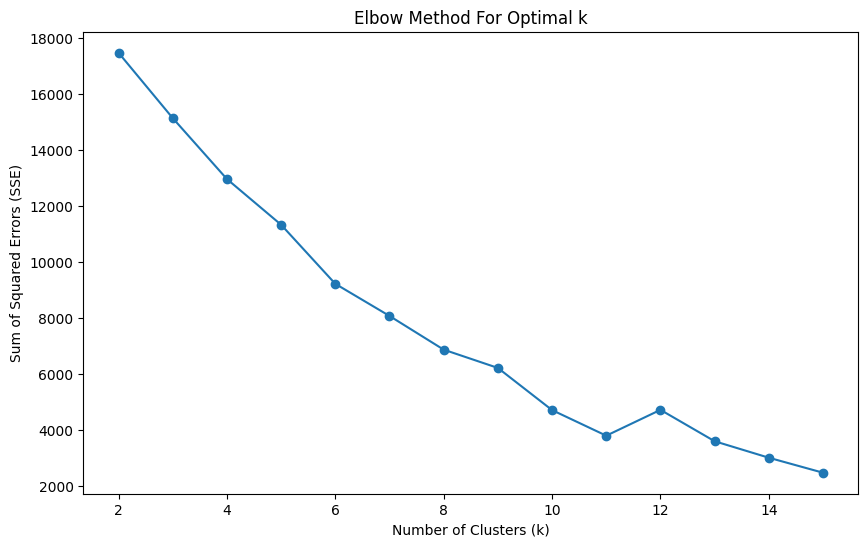

In [10]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

# Step 1: Create a list to store the SSE values for each k
sse = []

# Step 2: Test K-Means with different values of k (e.g., from 2 to 10 clusters)
for k in range(2, 16):
    kmeans = KMeans(featuresCol="clean_goods_word2vec", predictionCol="cluster", k=k)
    kmeans_model = kmeans.fit(df_word2vec)
    
    # Compute the Sum of Squared Errors (SSE) and append to the list
    sse.append(kmeans_model.summary.trainingCost)

# Step 3: Plot the SSE against k to find the "elbow" point
plt.figure(figsize=(10,6))
plt.plot(range(2, 16), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.show()


In [11]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="clean_goods_word2vec", predictionCol="cluster", k=9)  # k is the number of clusters
kmeans_model = kmeans.fit(df_word2vec)

# Make predictions (assign clusters to the data points)
df_clusters = kmeans_model.transform(df_word2vec)

# Show the resulting DataFrame with clusters
df_clusters.select("clean_goods", "clean_goods_word2vec", "cluster").show(truncate=False)

+-----------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|clean_goods                                                      |clean_goods_word2vec                                                                                                                                                                                         |cluster|
+-----------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|[watch, clock, jewelry, repair]                                  |[-0.3182933870702982,0.8978457897901535,1.272992581129074,-0.3029742483049631,0.7808161

In [12]:
from pyspark.sql.functions import explode, col, desc, count
from pyspark.sql import Window
from pyspark.sql.functions import row_number

# Step 1: Explode the 'clean_goods' column to individual clean_good entries
df_exploded = df_clusters.withColumn("clean_good", explode(col("clean_goods")))

# Step 2: Group by 'cluster' and 'clean_good', then count occurrences of each clean_good
df_grouped = df_exploded.groupBy("cluster", "clean_good").count()

# Step 3: Rank clean_goods within each cluster based on count
window = Window.partitionBy("cluster").orderBy(desc("count"))
df_ranked = df_grouped.withColumn("rank", row_number().over(window))

# Step 4: Filter to keep only the most common clean_good per cluster
df_most_common_good = df_ranked.filter(col("rank") == 1).drop("rank")

# Step 5: Show the most common clean_good for each cluster
df_most_common_good.select("cluster", "clean_good", "count").show(truncate=False)

# Step 6: Count the number of records (merchants) in each cluster
df_cluster_count = df_clusters.groupBy("cluster").agg(count("*").alias("merchant_count"))

# Step 7: Show the number of records/merchants in each cluster
df_cluster_count.show(truncate=False)


+-------+----------+-----+
|cluster|clean_good|count|
+-------+----------+-----+
|0      |artist    |193  |
|1      |watch     |261  |
|2      |books     |359  |
|3      |television|175  |
|4      |computer  |372  |
|5      |furniture |316  |
|6      |health    |164  |
|7      |game      |142  |
|8      |music     |334  |
+-------+----------+-----+

+-------+--------------+
|cluster|merchant_count|
+-------+--------------+
|1      |261           |
|6      |325           |
|3      |345           |
|5      |316           |
|4      |372           |
|8      |167           |
|7      |142           |
|2      |899           |
|0      |1199          |
+-------+--------------+



In [13]:
df_most_common_good.count()

9

In [14]:
df_clusters.filter(col('cluster')==3).show(20, truncate=False)

+------------+---------------------------------+--------------------------------------------------------------+-------------+---------+------------------+-------------------+------------------+------------------+------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|merchant_abn|name                             |goods                                                         |revenue_level|take_rate|sum(dollar_value) |count(dollar_value)|log_ratio         |unscaled_earning  |clean_goods                               |clean_goods_word2vec                                                                                                                                                                                         |cluster|
+------------+---------------------------------+------------

In [15]:
from pyspark.sql.functions import when, col

# Define the mapping of clusters to segments
df_segmented = df_clusters.withColumn(
    "segment",
    when(col("cluster") == 0, "Entertainment & Media") #music
    .when(col("cluster") == 1, "Office & Home Supplies") #office
    .when(col("cluster") == 2, "Office & Home Supplies") #furniture
    .when(col("cluster") == 3, "Miscellaneous") #novelty
    .when(col("cluster") == 4, "Fashion") #jewelry
    .when(col("cluster") == 5, "Entertainment & Media") #television
    .when(col("cluster") == 6, "Miscellaneous") #shoe
    .when(col("cluster") == 7, "Miscellaneous") #craft
    .when(col("cluster") == 8, "Technology") #computer
)

# Show the DataFrame with the assigned segments
df_segmented.select("cluster", "clean_goods", "segment").show(truncate=False)


+-------+-----------------------------------------------------------------+----------------------+
|cluster|clean_goods                                                      |segment               |
+-------+-----------------------------------------------------------------+----------------------+
|1      |[watch, clock, jewelry, repair]                                  |Office & Home Supplies|
|0      |[motor, vehicle]                                                 |Entertainment & Media |
|3      |[cable, satellite, pay, television, radio]                       |Miscellaneous         |
|0      |[opticians, optical, goods, eyeglasses]                          |Entertainment & Media |
|1      |[watch, clock, jewelry, repair]                                  |Office & Home Supplies|
|0      |[antique, repairs]                                               |Entertainment & Media |
|2      |[tent, awning]                                                   |Office & Home Supplies|
|3      |[

In [16]:
df_segmented.select("segment", "merchant_abn", "goods").write.mode('overwrite').parquet("../data/curated/clean_merchant_segmented.parquet")

## Ranking with respect to each segment

In [17]:
initial_ranking = spark.read.parquet("../data/curated/merchant_ranking")
merchant_segment = spark.read.parquet("../data/curated/clean_merchant_segmented.parquet")

In [18]:
# Join each merchant in initial ranking by segment
merchant_segment_ranking = initial_ranking.join(merchant_segment, how='left', on='merchant_abn')

In [19]:
df_segmented.select("segment", "merchant_abn", "goods").write.mode('overwrite').parquet("../data/curated/clean_merchant_segmented.parquet")

## Ranking with respect to each segment

In [20]:
initial_ranking = spark.read.parquet("../data/curated/merchant_ranking")
merchant_segment = spark.read.parquet("../data/curated/clean_merchant_segmented.parquet")

In [21]:
# Join each merchant in initial ranking by segment
merchant_segment_ranking = initial_ranking.join(merchant_segment, how='left', on='merchant_abn')

In [22]:
merchant_segment_ranking.show()

+------------+-------------------+--------------------+--------------------+
|merchant_abn|        final_score|             segment|               goods|
+------------+-------------------+--------------------+--------------------+
| 10023283211|0.34665547847970696|Entertainment & M...|furniture, home f...|
| 10142254217|0.44591396713468606|       Miscellaneous|cable, satellite,...|
| 10187291046|0.38122776560117516|Office & Home Sup...|watch, clock, and...|
| 10192359162|  0.398765863870318|          Technology|music shops - mus...|
| 10206519221|0.47225008406806857|Office & Home Sup...|gift, card, novel...|
| 10255988167| 0.4076161630342327|             Fashion|computers, comput...|
| 10264435225| 0.3963824321769272|Office & Home Sup...|watch, clock, and...|
| 10279061213| 0.4276492868603308|             Fashion|computer programm...|
| 10323485998| 0.4740691202301806|Entertainment & M...|furniture, home f...|
| 10342410215|0.40444552007740514|             Fashion|computers, comput...|

In [23]:
segments = [
    "Entertainment & Media",
    "Office & Home Supplies",
    "Miscellaneous",
    "Fashion",
    "Technology"
]

for segment in segments:
    print(segment)
    segment_ranking = merchant_segment_ranking.filter(F.col('segment') == segment)
    segment_ranking.orderBy(F.col('final_score').desc()).show(10)

Entertainment & Media
+------------+------------------+--------------------+--------------------+
|merchant_abn|       final_score|             segment|               goods|
+------------+------------------+--------------------+--------------------+
| 46804135891|0.6777120982876664|Entertainment & M...|opticians, optica...|
| 63290521567|0.6749088816613451|Entertainment & M...|artist supply and...|
| 95824231566|0.6706274916780242|Entertainment & M...|art dealers and g...|
| 48534649627|0.6314486821874987|Entertainment & M...|opticians, optica...|
| 11566786699|0.5916917142803533|Entertainment & M...|opticians, optica...|
| 76767266140|0.5855104410046132|Entertainment & M...|furniture, home f...|
| 41251795489|0.5822142200359555|Entertainment & M...|opticians, optica...|
| 47797405944|0.5736721249679044|Entertainment & M...|art dealers and g...|
| 38090089066|0.5658846908843367|Entertainment & M...|furniture, home f...|
| 42355028515|0.5651065692159134|Entertainment & M...|lawn and gar